<a href="https://colab.research.google.com/github/KumailKamali1118/Showing-CSV-file-into-Graph/blob/main/cv_lab_5_transfer_learning_and_data_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>




# Transfer Learning
In this notebook, we will perform transfer learning to train CIFAR-10 dataset on ResNet50 model available in Keras.



## Imports

In [2]:
import os, re, time, json
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds

print("Tensorflow version " + tf.__version__)

Tensorflow version 2.12.0


## Parameters

- Define the batch size
- Define the class (category) names

In [3]:
BATCH_SIZE = 32
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Define some functions that will help us to create some visualizations.

In [4]:


# utility to display training and validation curves
def plot_metrics(metric_name, title, ylim=5):
  plt.title(title)
  plt.ylim(0,ylim)
  plt.plot(history.history[metric_name],color='blue',label=metric_name)
  plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)

## Loading and Preprocessing Data
[CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset has 32 x 32 RGB images belonging to 10 classes. We will load the dataset from Keras.

In [5]:
(training_images, training_labels) , (validation_images, validation_labels) = tf.keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 13s 0us/step


### Visualize Train Dataset



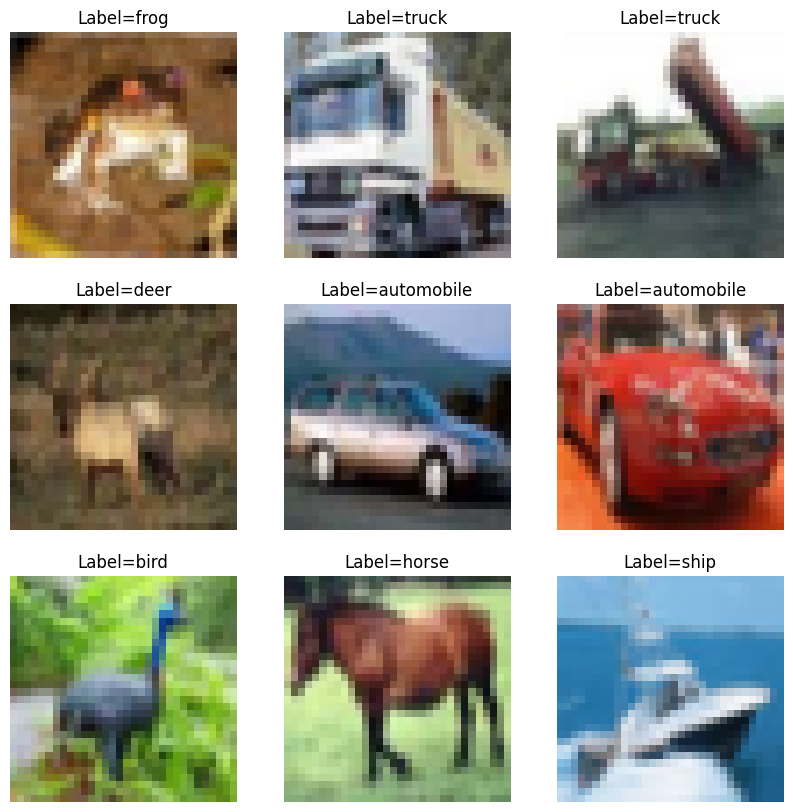

In [6]:
# Create a subplot
plt.figure(figsize=(10, 10))
for i in range(9):

      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(training_images[i], cmap='gray')
      plt.title("Label="+label_names[ training_labels[i][0]])
      plt.axis('off')

# Show the subplot
plt.show()

### Visualize Test Dataset

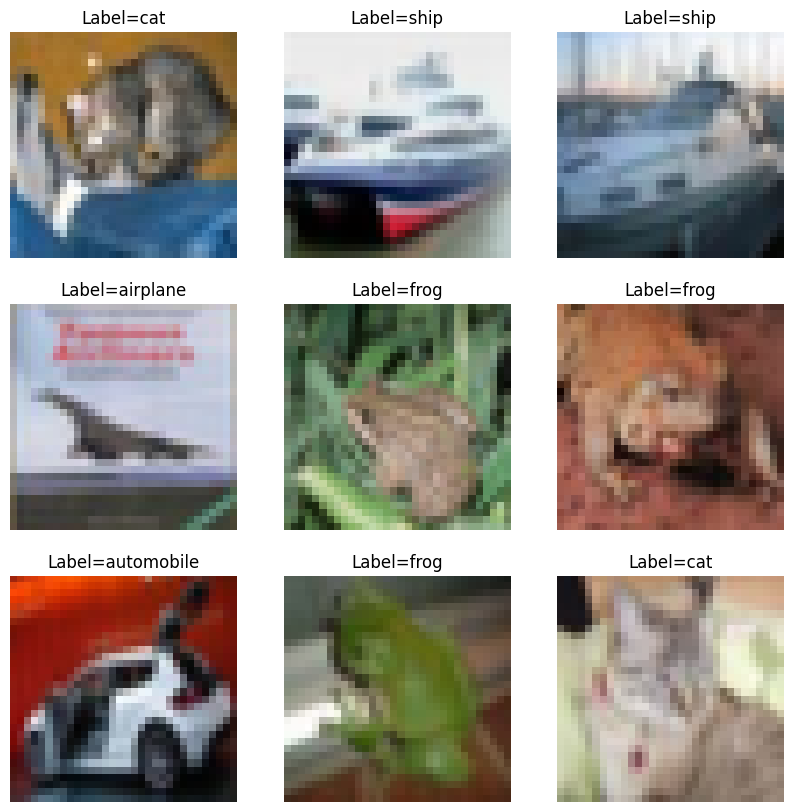

In [7]:
# Create a subplot
plt.figure(figsize=(10, 10))
for i in range(9):

      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(validation_images[i], cmap='gray')
      plt.title("Label="+label_names[ validation_labels[i][0]])
      plt.axis('off')

plt.show()

### Preprocess Dataset
Here, we'll perform normalization on images in training and validation set.
- We'll use the function [preprocess_input](https://github.com/keras-team/keras-applications/blob/master/keras_applications/resnet50.py) from the ResNet50 model in Keras.

In [8]:
#trfd=tf.keras.applications.resnet50.preprocess_input(training_images)

In [9]:
#trfd.shape

In [10]:
def preprocess_image_input(input_images):
  input_images = input_images.astype('float32')
  output_ims = tf.keras.applications.resnet50.preprocess_input(input_images)
  return output_ims


In [11]:
train_X = preprocess_image_input(training_images)
valid_X = preprocess_image_input(validation_images)

## Define the Network
We will be performing transfer learning on **ResNet50** available in Keras.
- We'll load pre-trained **imagenet weights** to the model.
- We'll choose to retain all layers of **ResNet50** along with the final classification layers.

In [12]:
'''
Feature Extraction is performed by ResNet50 pretrained on imagenet weights.
Input size is 224 x 224.
'''
def feature_extractor(inputs):

  feature_extractor = tf.keras.applications.resnet.ResNet50(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')(inputs)
  return feature_extractor


'''
Defines final dense layers and subsequent softmax layer for classification.
'''
def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dense(10, activation="softmax", name="classification")(x)
    return x

'''
Since input image size is (32 x 32), first upsample the image by factor of (7x7) to transform it to (224 x 224)
Connect the feature extraction and "classifier" layers to build the model.
'''
def final_model(inputs):

    resize = tf.keras.layers.UpSampling2D(size=(7,7))(inputs)

    resnet_feature_extractor = feature_extractor(resize)
    classification_output = classifier(resnet_feature_extractor)

    return classification_output

'''
Define the model and compile it.
Use Stochastic Gradient Descent as the optimizer.
Use Sparse Categorical CrossEntropy as the loss function.
'''
def define_compile_model():
  inputs = tf.keras.layers.Input(shape=(32,32,3))

  classification_output = final_model(inputs)
  model = tf.keras.Model(inputs=inputs, outputs = classification_output)

  model.compile(optimizer='SGD',
                loss='sparse_categorical_crossentropy',
                metrics = ['accuracy'])

  return model


model = define_compile_model()

model.summary()

94765736/94765736 [==============================] - 5s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                              

## Train the model

In [13]:
EPOCHS = 3
history = model.fit(train_X, training_labels, epochs=EPOCHS, validation_data = (valid_X, validation_labels), batch_size=128)

Epoch 1/3
391/391 [==============================] - 557s 1s/step - loss: 0.5502 - accuracy: 0.8231 - val_loss: 0.2400 - val_accuracy: 0.9208
Epoch 2/3
391/391 [==============================] - 528s 1s/step - loss: 0.1496 - accuracy: 0.9510 - val_loss: 0.1949 - val_accuracy: 0.9328
Epoch 3/3
391/391 [==============================] - 529s 1s/step - loss: 0.0630 - accuracy: 0.9821 - val_loss: 0.1828 - val_accuracy: 0.9401


## Evaluate the Model

Calculate the loss and accuracy metrics using the model's `.evaluate` function.

In [14]:
loss, t_accuracy = model.evaluate(train_X, training_labels, batch_size=64)

782/782 [==============================] - 136s 171ms/step - loss: 0.0306 - accuracy: 0.9940


In [15]:

loss, v_accuracy = model.evaluate(valid_X, validation_labels, batch_size=64)

157/157 [==============================] - 27s 172ms/step - loss: 0.1828 - accuracy: 0.9401


In [16]:
print("Train Acc:",t_accuracy)
print("Test Acc:",v_accuracy)

Train Acc: 0.9939799904823303
Test Acc: 0.9401000142097473


1/1 [==============================] - 0s 39ms/step


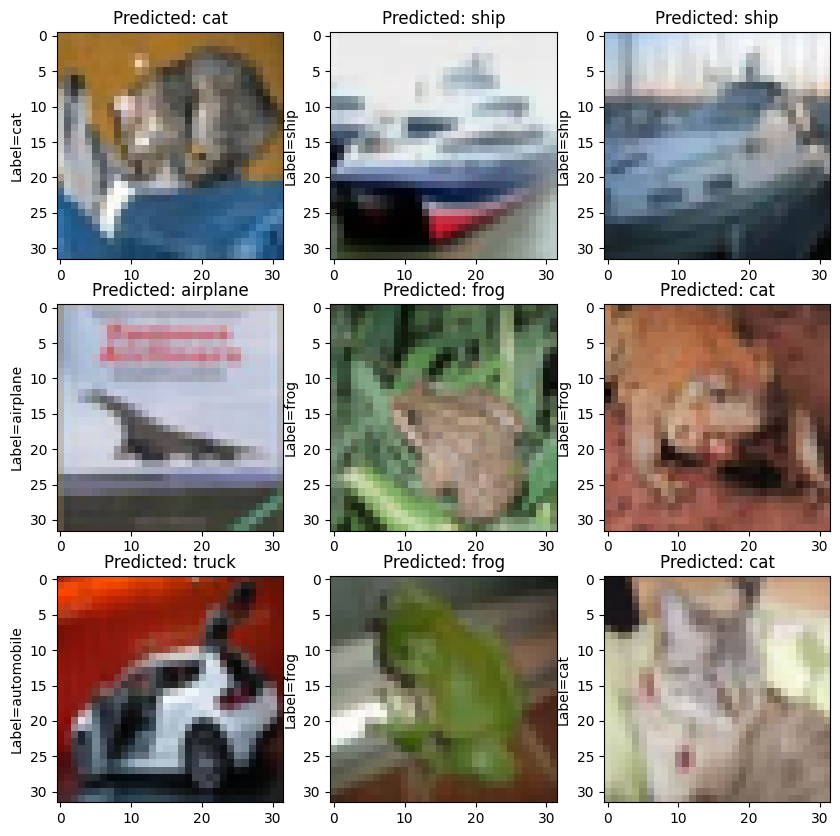

In [17]:
# Predict the label for 9 images
test_images_9 = validation_images[:9]
test_labels_9 = validation_labels[:9]
# Create a subplot
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

for i in range(9):
  test_images_9_1 = np.reshape(test_images_9[i], (1, 32, 32,3))
  prediction = model.predict(test_images_9_1)
  axes[i // 3, i % 3] = plt.subplot(3, 3, i + 1)
  axes[i // 3, i % 3].imshow(test_images_9[i])
  axes[i // 3, i % 3].set_title(f"Predicted: {label_names[prediction.argmax()] }")
  axes[i // 3, i % 3].set_ylabel("Label="+label_names[test_labels_9[i][0]])

plt.show()

# Data Augmentation


![](http://)

In [18]:
(training_images, training_labels) , (validation_images, validation_labels) = tf.keras.datasets.cifar10.load_data()

In [19]:
#img = preprocess_image_input(validation_images)

In [20]:
train_X = preprocess_image_input(training_images)
valid_X = preprocess_image_input(validation_images)

## Data Augmentation using ImageDataGenerator

In [21]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

# Create an instance of the ImageDataGenerator class.
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
)

# Load the images.
train_X = datagen.flow(
    train_X,
    training_labels,
    batch_size=32,

)

valid_X = datagen.flow(
    valid_X,
    validation_labels,
    batch_size=32,

)


In [22]:
EPOCHS = 3
history = model.fit(train_X, epochs=3, validation_data = (valid_X), batch_size=64)

Epoch 1/3
1563/1563 [==============================] - 555s 351ms/step - loss: 0.6652 - accuracy: 0.7692 - val_loss: 0.5398 - val_accuracy: 0.8174
Epoch 2/3
1563/1563 [==============================] - 536s 343ms/step - loss: 0.4607 - accuracy: 0.8399 - val_loss: 0.4416 - val_accuracy: 0.8478
Epoch 3/3
1563/1563 [==============================] - 535s 342ms/step - loss: 0.3871 - accuracy: 0.8663 - val_loss: 0.3986 - val_accuracy: 0.8622


In [23]:
loss, t_accuracy = model.evaluate(train_X, training_labels, batch_size=64)
loss, v_accuracy = model.evaluate(valid_X, validation_labels, batch_size=64)
print("Train Acc:",t_accuracy)
print("Test Acc:",v_accuracy)

ValueError: ignored